# Global

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    root_path = "/content/drive/MyDrive/Try_Robotics2_project/"
except:
    root_path = "./"

In [2]:
global opt_update, get_params, nn_forward_fn
global best_params, best_loss

# Imports

In [3]:
import argparse
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl

from copy import deepcopy as copy
from functools import partial # reduces arguments to function by making some subset implicit
from jax import jit
from jax import random
from jax.example_libraries import stax
from jax.example_libraries.stax import serial, Dense, Softplus, Tanh, elementwise, Relu
from jax.example_libraries import optimizers
from jax.experimental.ode import odeint
from jax.tree_util import tree_flatten
from tqdm import tqdm

# Utils

In [4]:
def wrap_coords(state):
  # wrap generalized coordinates to [-pi, pi]
  return jnp.concatenate([(state[:2] + jnp.pi) % (2 * jnp.pi) - jnp.pi, state[2:]])

def rk4_step(f, x, t, h):
  # one step of Runge-Kutta integration
  k1 = h * f(x, t)
  k2 = h * f(x + k1/2, t + h/2)
  k3 = h * f(x + k2/2, t + h/2)
  k4 = h * f(x + k3, t + h)
  return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

def radial2cartesian(t1, t2, l1, l2):
  # Convert from radial to Cartesian coordinates.
  x1 = l1 * jnp.sin(t1)
  y1 = -l1 * jnp.cos(t1)
  x2 = x1 + l2 * jnp.sin(t2)
  y2 = y1 - l2 * jnp.cos(t2)
  return x1, y1, x2, y2

def write_to(data, path):
  with open(path, 'wb') as f:
    pkl.dump(data, f, protocol=pkl.HIGHEST_PROTOCOL)

def read_from(path):
  with open(path, 'rb') as f:
    data = pkl.load(f)
  return data

def plot_loss(train_losses, test_losses):
  fig, ax = plt.subplots(1, 1)

  ax.plot(train_losses, label='Train loss')
  ax.plot(test_losses, label='Test loss')
  ax.set_ylabel("Loss")
  ax.set_xlabel("Epochs")
  ax.legend()

  fig.tight_layout()

# Lagrangian Dynamics

In [5]:
# unconstrained equation of motion
def unconstrained_eom(model, state, t=None):
  q, q_t = jnp.split(state, 2)
  return jnp.concatenate([model(q, q_t)])

# lagrangian equation of motion
def lagrangian_eom(lagrangian, state, t=None):
  q, q_t = jnp.split(state, 2)
  #Note: the following line assumes q is an angle. Delete it for problems other than double pendulum.
  q = q % (2*jnp.pi)
  q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t))
          @ (jax.grad(lagrangian, 0)(q, q_t)
             - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
  dt = 1e-1
  return dt*jnp.concatenate([q_t, q_tt])

def raw_lagrangian_eom(lagrangian, state, t=None):
  q, q_t = jnp.split(state, 2)
  q = q % (2*jnp.pi)
  q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t))
          @ (jax.grad(lagrangian, 0)(q, q_t)
             - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
  return jnp.concatenate([q_t, q_tt])

def lagrangian_eom_rk4(lagrangian, state, n_updates, Dt=1e-1, t=None):
    @jax.jit
    def cur_fnc(state):
        q, q_t = jnp.split(state, 2)
        q = q % (2*jnp.pi)
        q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t))
                 @ (jax.grad(lagrangian, 0)(q, q_t)
                 - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
        return jnp.concatenate([q_t, q_tt])

    @jax.jit
    def get_update(update):
        dt = Dt/n_updates
        cstate = state + update
        k1 = dt*cur_fnc(cstate)
        k2 = dt*cur_fnc(cstate + k1/2)
        k3 = dt*cur_fnc(cstate + k2/2)
        k4 = dt*cur_fnc(cstate + k3)
        return update + 1.0/6.0 * (k1 + 2*k2 + 2*k3 + k4)

    update = 0
    for _ in range(n_updates):
        update = get_update(update)
    return update


def solve_dynamics(dynamics_fn, initial_state, is_lagrangian=True, **kwargs):
  eom = lagrangian_eom if is_lagrangian else unconstrained_eom

  # We currently run odeint on CPUs only, because its cost is dominated by
  # control flow, which is slow on GPUs.
  @partial(jax.jit, backend='cpu')
  def f(initial_state):
    return odeint(partial(eom, dynamics_fn), initial_state, **kwargs)
  return f(initial_state)


def custom_init(init_params, seed=0):
    """Do an optimized LNN initialization for a simple uniform-width MLP"""
    import numpy as np
    new_params = []
    rng = jax.random.PRNGKey(seed)
    i = 0
    number_layers = len([0 for l1 in init_params if len(l1) != 0])
    for l1 in init_params:
        if (len(l1)) == 0: new_params.append(()); continue
        new_l1 = []
        for l2 in l1:
            if len(l2.shape) == 1:
                #Zero init biases
                new_l1.append(jnp.zeros_like(l2))
            else:
                n = max(l2.shape)
                first = int(i == 0)
                last = int(i == number_layers - 1)
                mid = int((i != 0) * (i != number_layers - 1))
                mid *= i

                std = 1.0/np.sqrt(n)
                std *= 2.2*first + 0.58*mid + n*last

                if std == 0:
                    raise NotImplementedError("Wrong dimensions for MLP")

                new_l1.append(jax.random.normal(rng, l2.shape)*std)
                rng += 1
                i += 1

        new_params.append(new_l1)

    return new_params

# Physics

In [6]:
a = 50
@jit
def test_kinetic_energy(state, m1=0.25, l1=0.3, g=9.81, I=0.01125, d1=0.15, Im=0.0128,k=a):
  q, q_dot = jnp.split(state,2)
  (t1, t2), (w1, w2) = q, q_dot

  T1 = 0.5 * (I+m1*(d1**2)) * (w1**2)
  T2 = 0.5 * Im * (w2**2)
  T = T1 + T2
  return T

@jit
def test_potential_energy(state, m1=0.25, l1=0.3, g=9.81, I=0.01125, d1=0.15, Im=0.0128,k=a):
  q, q_dot = jnp.split(state,2)
  (t1, t2), (w1, w2) = q, q_dot

  Ug = -m1*g*d1*jnp.cos(t1)
  Ue = 0.5*k*((t1-t2)**2)
  V = Ug+Ue
  return V
@jit
def kinetic_energy(q, q_dot, m1=0.25, l1=0.3, g=9.81, I=0.01125, d1=0.15, Im=0.0128,k=a):
  (t1, t2), (w1, w2) = q, q_dot

  T1 = 0.5 * (I+m1*(d1**2)) * (w1**2)
  T2 = 0.5 * Im * (w2**2)
  T = T1 + T2
  return T

@jit
def potential_energy(q, q_dot, m1=0.25, l1=0.3, g=9.81, I=0.01125, d1=0.15, Im=0.0128,k=a):
  (t1, t2), (w1, w2) = q, q_dot

  Ug = -m1*g*d1*jnp.cos(t1)
  Ue = 0.5*k*((t1-t2)**2)
  V = Ug+Ue
  return V

# Double pendulum lagrangian
@jit
def lagrangian_fn(q, q_dot, m1=0.25, l1=0.3, g=9.81, I=0.01125, d1=0.15, Im=0.0128,k=a):
  (t1, t2), (w1, w2) = q, q_dot

  T = kinetic_energy(q, q_dot)
  V = potential_energy(q, q_dot)
  return jnp.sum(T - V)

# Double pendulum lagrangian
@jit
def hamiltonian_fn(q, q_dot, m1=0.25, l1=0.3, g=9.81, I=0.01125, d1=0.15, Im=0.0128,k=a):
  (t1, t2), (w1, w2) = q, q_dot

  T = kinetic_energy(q, q_dot)
  V = potential_energy(q, q_dot)
  return T + V

# Double pendulum dynamics via analytical forces taken from Diego's blog
@jit
def analytical_fn(state, t=0, m1=0.25, l1=0.3, g=9.81, I=0.01125, d1=0.15, Im=0.0128,k=a):
  t1, t2, w1, w2 = state
  a1 = 0
  a2 = 0
  f1 = (-m1*g*d1*jnp.sin(t1)+k*(t1-t2))/(I+m1*(d1**2))
  f2 = k*(t1-t2)/Im
  g1 = f1
  g2 = f2
  return jnp.stack([w1, w2, g1, g2])

@jit
def analytical_ffn(state, t=0, m1=0.25, l1=0.3, g=9.81, I=0.01125, d1=0.15, Im=0.0128,k=0):
  t1, t2, w1, w2 = state
  a1 = 0
  a2 = 0
  f1 = (-m1*g*d1*jnp.sin(t1)+k*(t1-t2))/(I+m1*(d1**2))
  f2 = k*(t1-t2)/Im
  g1 = f1
  g2 = f2
  return jnp.stack([w1, w2, g1, g2])


# Data

In [7]:
@partial(jax.jit, backend='cpu')
def get_trajectory(y0, times, use_lagrangian=False, **kwargs):
  if use_lagrangian:
    y = solve_dynamics(lagrangian_fn, y0, t=times, is_lagrangian=True, rtol=1e-10, atol=1e-10, **kwargs)
  else:
    y = odeint(analytical_fn, y0, t=times, rtol=1e-10, atol=1e-10, **kwargs)
  return y

@partial(jax.jit, backend='cpu')
def get_trajectory_lagrangian(y0, times, **kwargs):
  return solve_dynamics(lagrangian_fn, y0, t=times, is_lagrangian=True, rtol=1e-10, atol=1e-10, **kwargs)

@partial(jax.jit, backend='cpu')
def get_trajectory_analytic(y0, times, **kwargs):
    return odeint(analytical_fn, y0, t=times, rtol=1e-10, atol=1e-10, **kwargs)

@partial(jax.jit, backend='cpu')
def get_trajectory_analytic2(y0, times, **kwargs):
    return odeint(analytical_ffn, y0, t=times, rtol=1e-10, atol=1e-10, **kwargs)

def test_dataset(rng, samples=1, t_span=[0, 10], fps=100, test_split=0.5, lookahead=1,
                    unlimited_steps=False, init_pos=2.0*np.pi, init_vel=0.1, mot_pos=2.0*np.pi, mot_vel=0.1, **kwargs):
    data = {'meta': locals()}
    vfnc = jax.jit(jax.vmap(analytical_fn))
    vget = partial(jax.jit, backend='cpu')(jax.vmap(partial(get_trajectory_analytic, mxstep=100), (0, None), 0))
    vget_unlimited = partial(jax.jit, backend='cpu')(jax.vmap(partial(get_trajectory_analytic), (0, None), 0))
    # randomly sample inputs

    frames = int(fps*(t_span[1]-t_span[0]))
    times = jnp.linspace(t_span[0], t_span[1], frames)
    y0 = jnp.concatenate([
        jax.random.uniform(rng,(samples,1))*init_pos,
        jax.random.uniform(rng+2,(samples,1))*mot_pos,
        jax.random.uniform(rng+1,(samples,1))*init_vel,
        jax.random.uniform(rng+3,(samples,1))*mot_vel
    ], axis=1)

    if unlimited_steps:
      y = vget(y0, times)
    else:
      y = vget_unlimited(y0, times)

    data['x'] = y[:, :-lookahead]
    data['dx'] = y[:, lookahead:] - data['x']
    data['x'] = jnp.concatenate(data['x'])
    data['dx'] = jnp.concatenate(data['dx'])
    data['t'] = jnp.tile(times[:-lookahead], (samples,))

    # make a train/test split
    split_ix = int(len(data['x']) * test_split)
    split_data = {}
    for k in ['x', 'dx', 't']:
        split_data[k], split_data['test_' + k] = data[k][:split_ix], data[k][split_ix:]
    data = split_data
    return data

def noise_test_dataset(rng, samples=1, t_span=[0, 10], fps=100, test_split=0.5, lookahead=1,
                    unlimited_steps=False, init_pos=2.0*np.pi, init_vel=0.1, mot_pos=2.0*np.pi, mot_vel=0.1, **kwargs):
    data = {'meta': locals()}
    vfnc = jax.jit(jax.vmap(analytical_fn))
    vget = partial(jax.jit, backend='cpu')(jax.vmap(partial(get_trajectory_analytic, mxstep=100), (0, None), 0))
    vget_unlimited = partial(jax.jit, backend='cpu')(jax.vmap(partial(get_trajectory_analytic), (0, None), 0))
    # randomly sample inputs

    frames = int(fps*(t_span[1]-t_span[0]))
    times = jnp.linspace(t_span[0], t_span[1], frames)
    y0 = jnp.concatenate([
        jax.random.uniform(rng,(samples,1))*init_pos,
        jax.random.uniform(rng+2,(samples,1))*mot_pos,
        jax.random.uniform(rng+1,(samples,1))*init_vel,
        jax.random.uniform(rng+3,(samples,1))*mot_vel
    ], axis=1)

    if unlimited_steps:
      y = vget(y0, times)
    else:
      y = vget_unlimited(y0, times)

    data['x'] = y[:, :-lookahead]
    data['x'] += jax.random.uniform(rng, data['x'].shape)*np.pi/2
    data['dx'] = y[:, lookahead:] - data['x']
    data['x'] = jnp.concatenate(data['x'])
    data['dx'] = jnp.concatenate(data['dx'])
    data['t'] = jnp.tile(times[:-lookahead], (samples,))

    # make a train/test split
    split_ix = int(len(data['x']) * test_split)
    split_data = {}
    for k in ['x', 'dx', 't']:
        split_data[k], split_data['test_' + k] = data[k][:split_ix], data[k][split_ix:]
    data = split_data
    return data

def energy_test_dataset(rng, samples=1, t_span=[0, 10], fps=100, test_split=0.5, lookahead=1,
                    unlimited_steps=False, init_pos=2.0*np.pi, init_vel=0.1, mot_pos=2.0*np.pi, mot_vel=0.1, **kwargs):
    data = {'meta': locals()}

    # randomly sample inputs
    vget = partial(jax.jit, backend='cpu')(jax.vmap(partial(get_trajectory_analytic, mxstep=100), (0, None), 0))
    vget_unlimited = partial(jax.jit, backend='cpu')(jax.vmap(partial(get_trajectory_analytic), (0, None), 0))
    venergy = partial(jax.jit, backend='cpu')(jax.vmap(partial(get_trajectory_lagrangian), (0, None), 0))

    frames = int(fps*(t_span[1]-t_span[0]))
    times = jnp.linspace(t_span[0], t_span[1], frames)
    y0 = jnp.concatenate([
        jax.random.uniform(rng,(samples,1))*init_pos,
        jax.random.uniform(rng+2,(samples,1))*mot_pos,
        jax.random.uniform(rng+1,(samples,1))*init_vel,
        jax.random.uniform(rng+3,(samples,1))*mot_vel
    ], axis=1)

    print("Initial pos: ",y0[0][0])
    print("Initial mot pos: ",y0[0][1])
    print("Initial vel: ",y0[0][2])
    print("Initial mot vel: ",y0[0][3])

    if unlimited_steps:
        y = vget(y0, times)
    else:
        y = venergy(y0,times)
      


    #This messes it up!
#     y = np.concatenate(((y[..., :2]%(2*np.pi)) - np.pi, y[..., 2:]), axis=2)

    data['x'] = y[:, :-lookahead]
    data['dx'] = y[:, lookahead:] - data['x']
    data['x'] = jnp.concatenate(data['x'])
    data['dx'] = jnp.concatenate(data['dx'])
    data['t'] = jnp.tile(times[:-lookahead], (samples,))

    # make a train/test split
    split_ix = int(len(data['x']) * test_split)
    split_data = {}
    for k in ['x', 'dx', 't']:
        split_data[k], split_data['test_' + k] = data[k][:split_ix], data[k][split_ix:]
    data = split_data
    return data

def conv_test_dataset(rng, samples=1, t_span=[0, 10], fps=100, test_split=0.5, lookahead=1,
                    unlimited_steps=False, init_pos=2.0*np.pi, init_vel=0.1, mot_pos=2.0*np.pi, mot_vel=0.1, **kwargs):
    data = {'meta': locals()}

    # randomly sample inputs
    vget = partial(jax.jit, backend='cpu')(jax.vmap(partial(get_trajectory_analytic, mxstep=100), (0, None), 0))
    vget_unlimited2 = partial(jax.jit, backend='cpu')(jax.vmap(partial(get_trajectory_analytic2), (0, None), 0))
    venergy = partial(jax.jit, backend='cpu')(jax.vmap(partial(get_trajectory_lagrangian), (0, None), 0))

    frames = int(fps*(t_span[1]-t_span[0]))
    times = jnp.linspace(t_span[0], t_span[1], frames)
    y0 = jnp.concatenate([
        jax.random.uniform(rng,(samples,1))*init_pos,
        jax.random.uniform(rng+2,(samples,1))*mot_pos,
        jax.random.uniform(rng+1,(samples,1))*init_vel,
        jax.random.uniform(rng+3,(samples,1))*mot_vel
    ], axis=1)

    print("Initial pos: ",y0[0][0])
    print("Initial mot pos: ",y0[0][1])
    print("Initial vel: ",y0[0][2])
    print("Initial mot vel: ",y0[0][3])

    if unlimited_steps:
        y = vget(y0, times)
    else:
        y = vget_unlimited2(y0,times)
      


    #This messes it up!
#     y = np.concatenate(((y[..., :2]%(2*np.pi)) - np.pi, y[..., 2:]), axis=2)

    data['x'] = y[:, :-lookahead]
    data['dx'] = y[:, lookahead:] - data['x']
    data['x'] = jnp.concatenate(data['x'])
    data['dx'] = jnp.concatenate(data['dx'])
    data['t'] = jnp.tile(times[:-lookahead], (samples,))

    # make a train/test split
    split_ix = int(len(data['x']) * test_split)
    split_data = {}
    for k in ['x', 'dx', 't']:
        split_data[k], split_data['test_' + k] = data[k][:split_ix], data[k][split_ix:]
    data = split_data
    return data

# Test

Initial pos:  1.3321031
Initial mot pos:  1.5336735
Initial vel:  0.37069464
Initial mot vel:  0.2535444
Initial pos:  1.3321031
Initial mot pos:  1.5336735
Initial vel:  0.37069464
Initial mot vel:  0.2535444


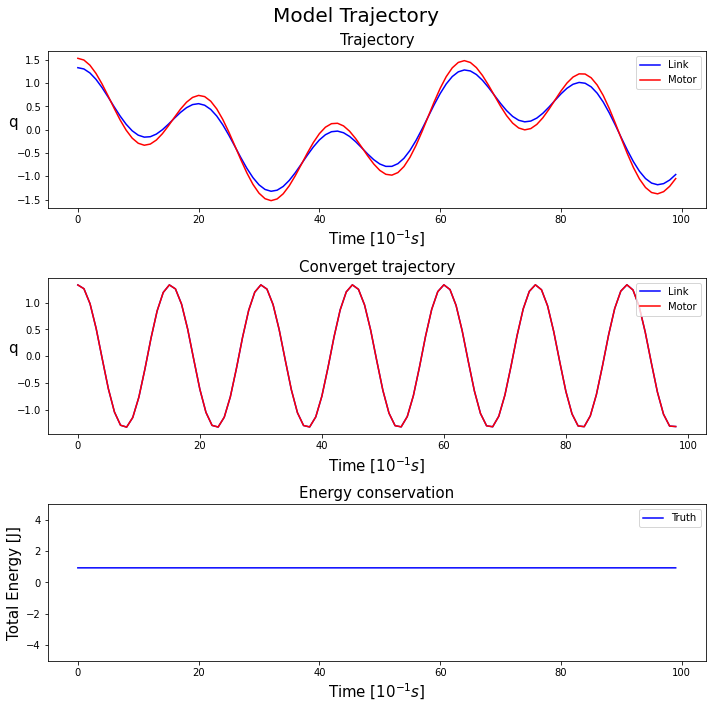

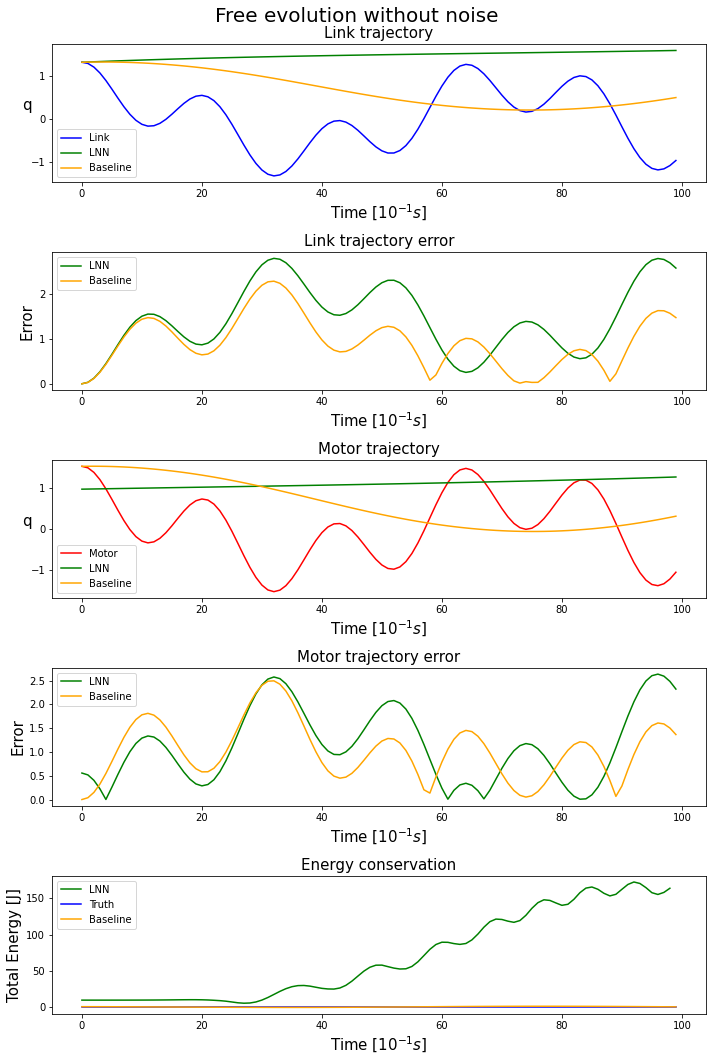

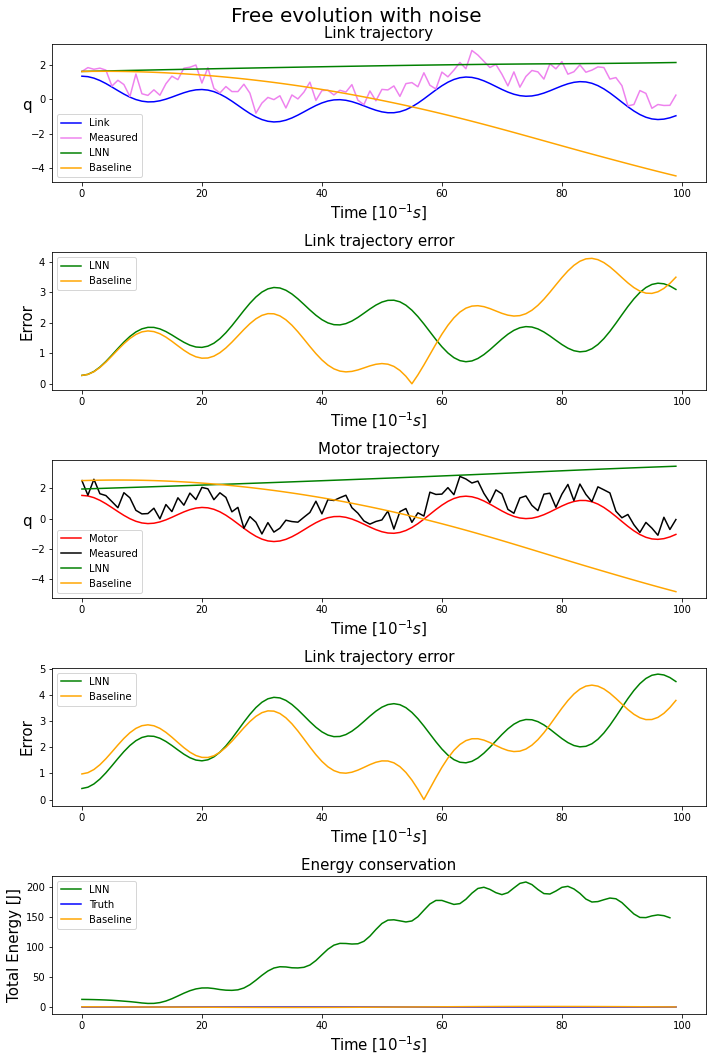

In [31]:
def test(lnn_path,baseline_path,exp_init_pos,exp_init_vel,exp_mot_pos,exp_mot_vel):
  max_t = 10
  fps = 100
  test_set = test_dataset(jax.random.PRNGKey(2),
                                t_span=[0, max_t],
                                fps=fps, test_split=1.0,
                                unlimited_steps=False,
                                init_pos=exp_init_pos,
                                init_vel=exp_init_vel,
                                mot_pos=exp_mot_pos,
                                mot_vel=exp_mot_vel)

  noise_set = noise_test_dataset(jax.random.PRNGKey(2),
                                t_span=[0, max_t],
                                fps=fps, test_split=1.0,
                                unlimited_steps=False,
                                init_pos=exp_init_pos,
                                init_vel=exp_init_vel,
                                mot_pos=exp_mot_pos,
                                mot_vel=exp_mot_vel)
  
  energy_set = energy_test_dataset(jax.random.PRNGKey(2),
                                t_span=[0, max_t],
                                fps=fps, test_split=1.0,
                                unlimited_steps=False,
                                init_pos=exp_init_pos,
                                init_vel=exp_init_vel,
                                mot_pos=exp_mot_pos,
                                mot_vel=exp_mot_vel)
  
  conv_set = conv_test_dataset(jax.random.PRNGKey(2),
                                t_span=[0, 10],
                                fps=10, test_split=1.0,
                                unlimited_steps=False,
                                init_pos=exp_init_pos,
                                init_vel=exp_init_vel,
                                mot_pos=exp_mot_pos,
                                mot_vel=exp_mot_vel)

  true_total_energy = (
      jax.vmap(test_kinetic_energy)(energy_set['x'][:]) + \
      jax.vmap(test_potential_energy)(energy_set['x'][:])
  )

  lnn_predictions = np.load(lnn_path[0])
  lnn_noise_predictions = np.load(lnn_path[1])
  lnn_total_energy = np.load(lnn_path[2])
  lnn_noise_total_energy = np.load(lnn_path[3])
  baseline_predictions = np.load(baseline_path[0])
  baseline_noise_predictions = np.load(baseline_path[1])
  baseline_total_energy = np.load(baseline_path[2])
  baseline_noise_total_energy = np.load(baseline_path[3])

  fig, ax = plt.subplots(3, 1, figsize=(10,10))

  fig.suptitle("Model Trajectory",fontsize=20)

  ax[0].set_title("Trajectory",fontsize=15)
  ax[0].plot(test_set['x'][:100, 0], label='Link', color='blue')
  ax[0].plot(test_set['x'][:100, 1], label='Motor', color='red')
  ax[0].set_ylabel('q',rotation=0,fontsize=15)
  ax[0].set_xlabel(r'Time [$10^{-1} s$]',fontsize=15)
  ax[0].legend()

  ax[1].set_title("Converget trajectory",fontsize=15)
  ax[1].plot(conv_set['x'][:100, 0], label='Link', color='blue')
  ax[1].plot(conv_set['x'][:100, 0], label='Motor', color='red')
  ax[1].set_ylabel('q',rotation=0,fontsize=15)
  ax[1].set_xlabel(r'Time [$10^{-1} s$]',fontsize=15)
  ax[1].legend()

  ax[2].set_title("Energy conservation",fontsize=15)
  ax[2].plot((true_total_energy[:100]),label='Truth', color='blue')
  ax[2].set_ylim([-5,5])
  ax[2].set_ylabel('Total Energy [J]',fontsize=15)
  ax[2].set_xlabel(r'Time [$10^{-1} s$]',fontsize=15)
  ax[2].legend()
  
  fig.tight_layout()

  fig, ax = plt.subplots(5, 1, figsize=(10,15))
  
  fig.suptitle("Free evolution without noise",fontsize=20)

  ax[0].set_title("Link trajectory",fontsize=15)
  ax[0].plot(test_set['x'][:100, 0], label='Link', color='blue')
  ax[0].plot(lnn_predictions[:100, 0], label='LNN', color='green')
  ax[0].plot(baseline_predictions[:100, 0], label='Baseline', color='orange')
  ax[0].set_ylabel('q',rotation=0,fontsize=15)
  ax[0].set_xlabel(r'Time [$10^{-1} s$]',fontsize=15)
  ax[0].legend()

  ax[1].set_title("Link trajectory error",fontsize=15)
  ax[1].plot(jnp.abs(-test_set['x'][:100, 0] + lnn_predictions[:100, 0]), label='LNN', color='green')
  ax[1].plot(jnp.abs(-test_set['x'][:100, 0] + baseline_predictions[:100, 0]), label='Baseline', color='orange')
  ax[1].set_ylabel('Error',fontsize=15)
  ax[1].set_xlabel(r'Time [$10^{-1} s$]',fontsize=15)
  ax[1].legend()
  
  ax[2].set_title("Motor trajectory",fontsize=15)
  ax[2].plot(test_set['x'][:100, 1], label='Motor', color='red')
  ax[2].plot(lnn_predictions[:100, 1], label='LNN', color='green')
  ax[2].plot(baseline_predictions[:100, 1], label='Baseline', color='orange')
  ax[2].set_ylabel('q',rotation=0,fontsize=15)
  ax[2].set_xlabel(r'Time [$10^{-1} s$]',fontsize=15)
  ax[2].legend()

  ax[3].set_title("Motor trajectory error",fontsize=15)
  ax[3].plot(jnp.abs(-test_set['x'][:100, 1] + lnn_predictions[:100, 1]), label='LNN', color='green')
  ax[3].plot(jnp.abs(-test_set['x'][:100, 1] + baseline_predictions[:100, 1]), label='Baseline', color='orange')
  ax[3].set_ylabel('Error',fontsize=15)
  ax[3].set_xlabel(r'Time [$10^{-1} s$]',fontsize=15)
  ax[3].legend()  

  ax[4].set_title("Energy conservation",fontsize=15)
  ax[4].plot((lnn_total_energy[:100]),label='LNN', color='green')
  ax[4].plot((true_total_energy[:100]),label='Truth', color='blue')
  ax[4].plot((baseline_total_energy[:100]),label='Baseline', color='orange')
  ax[4].set_ylabel('Total Energy [J]',fontsize=15)
  ax[4].set_xlabel(r'Time [$10^{-1} s$]',fontsize=15)
  ax[4].legend()

  fig.tight_layout()

  fig, ax = plt.subplots(5, 1, figsize=(10,15))

  fig.suptitle("Free evolution with noise",fontsize=20)

  ax[0].set_title("Link trajectory",fontsize=15)
  ax[0].plot(test_set['x'][:100, 0], label='Link', color='blue')
  ax[0].plot(noise_set['x'][:100, 0], label='Measured', color='violet')
  ax[0].plot(lnn_noise_predictions[:100, 0], label='LNN', color='green')
  ax[0].plot(baseline_noise_predictions[:100, 0], label='Baseline', color='orange')
  ax[0].set_ylabel('q',rotation=0,fontsize=15)
  ax[0].set_xlabel(r'Time [$10^{-1} s$]',fontsize=15)
  ax[0].legend()

  ax[1].set_title("Link trajectory error",fontsize=15)
  ax[1].plot(jnp.abs(-test_set['x'][:100, 0] + lnn_noise_predictions[:100, 0]), label='LNN', color='green')
  ax[1].plot(jnp.abs(-test_set['x'][:100, 0] + baseline_noise_predictions[:100, 0]), label='Baseline', color='orange')
  ax[1].set_ylabel('Error',fontsize=15)
  ax[1].set_xlabel(r'Time [$10^{-1} s$]',fontsize=15)
  ax[1].legend()

  ax[2].set_title("Motor trajectory",fontsize=15)
  ax[2].plot(test_set['x'][:100, 1], label='Motor', color='red')
  ax[2].plot(noise_set['x'][:100, 1], label='Measured', color='black')
  ax[2].plot(lnn_noise_predictions[:100, 1], label='LNN', color='green')
  ax[2].plot(baseline_noise_predictions[:100, 1], label='Baseline', color='orange')
  ax[2].set_ylabel('q',rotation=0,fontsize=15)
  ax[2].set_xlabel(r'Time [$10^{-1} s$]',fontsize=15)
  ax[2].legend()

  ax[3].set_title("Link trajectory error",fontsize=15)
  ax[3].plot(jnp.abs(-test_set['x'][:100, 1] + lnn_noise_predictions[:100, 1]), label='LNN', color='green')
  ax[3].plot(jnp.abs(-test_set['x'][:100, 1] + baseline_noise_predictions[:100, 1]), label='Baseline', color='orange')
  ax[3].set_ylabel('Error',fontsize=15)
  ax[3].set_xlabel(r'Time [$10^{-1} s$]',fontsize=15)
  ax[3].legend()

  ax[4].set_title("Energy conservation",fontsize=15)
  ax[4].plot((lnn_noise_total_energy[:100]),label='LNN', color='green')
  ax[4].plot((true_total_energy[:100]),label='Truth', color='blue')
  ax[4].plot((baseline_noise_total_energy[:100]),label='Baseline', color='orange')
  ax[4].set_ylabel('Total Energy [J]',fontsize=15)
  ax[4].set_xlabel(r'Time [$10^{-1} s$]',fontsize=15)
  ax[4].legend()

  fig.tight_layout()

# init_pos = 2.0*np.pi
# init_vel = 0.5
# mot_pos = np.pi
# mot_vel = 1

init_pos = np.pi
init_vel = 1
mot_pos = np.pi/2
mot_vel = 0.5

# lnn_path = [root_path + "Rigid/LNN/lnn_" + str(round(init_pos,2)) + "_" + str(round(init_vel,2)) + "_rigid_predictions.npy", #colab
#             root_path + "Rigid/LNN/lnn_" + str(round(init_pos,2)) + "_" + str(round(init_vel,2)) + "_rigid_noise_predictions.npy",
#             root_path + "Rigid/LNN/lnn_" + str(round(init_pos,2)) + "_" + str(round(init_vel,2)) + "_rigid_energy.npy"]

# lnn_path = [r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\LNN\Lnn_6.28_0.5_3.14_1_elastic_predictions_300_2.npy",
#             r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\LNN\Lnn_6.28_0.5_3.14_1_elastic_noise_predictions_300_2.npy",
#             r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\LNN\Lnn_6.28_0.5_3.14_1_elastic_energy_300_2.npy",
#             r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\LNN\Lnn_6.28_0.5_3.14_1_elastic_noise_energy_300_2.npy"]

# lnn_path = [r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\LNN\lnn_3.14_1_1.57_0.5_elastic_predictions_300_2.npy",
#             r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\LNN\lnn_3.14_1_1.57_0.5_elastic_noise_predictions_300_2.npy",
#             r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\LNN\lnn_3.14_1_1.57_0.5_elastic_energy_300_2.npy",
#             r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\LNN\lnn_3.14_1_1.57_0.5_elastic_noise_energy_300_2.npy"]

# lnn_path = [r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\LNN\lnn_6.28_0.5_3.14_1_elastic_predictions_500_4.npy",
#             r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\LNN\lnn_6.28_0.5_3.14_1_elastic_noise_predictions_500_4.npy",
#             r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\LNN\lnn_6.28_0.5_3.14_1_elastic_energy_500_4.npy",
#             r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\LNN\lnn_6.28_0.5_3.14_1_elastic_noise_energy_500_4.npy"]

# lnn_path = [r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\LNN\lnn_3.14_1_1.57_0.5_elastic_predictions_500_4.npy",
#             r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\LNN\lnn_3.14_1_1.57_0.5_elastic_noise_predictions_500_4.npy",
#             r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\LNN\lnn_3.14_1_1.57_0.5_elastic_energy_500_4.npy",
#             r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\LNN\lnn_3.14_1_1.57_0.5_elastic_noise_energy_500_4.npy"]

# lnn_path = [r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\LNN\lnn_traj.npy",
#             r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\LNN\lnn_traj_noise.npy",
#             r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\LNN\lnn_err.npy",
#             r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\LNN\lnn_err_noise.npy"]

lnn_path = [r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\LNN\lnn_traj_2.npy",
            r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\LNN\lnn_traj_2_noise.npy",
            r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\LNN\lnn_err_2.npy",
            r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\LNN\lnn_err_2_noise.npy"]

# lnn_path = [r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\LNN\lnn_6.28_0.5_3.14_1_elastic_predictions_700_5.npy",
#             r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\LNN\lnn_6.28_0.5_3.14_1_elastic_noise_predictions_700_5.npy",
#             r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\LNN\lnn_6.28_0.5_3.14_1_elastic_energy_700_5.npy",
#             r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\LNN\lnn_6.28_0.5_3.14_1_elastic_noise_energy_700_5.npy"]

# lnn_path = [r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\LNN\lnn_3.14_1_1.57_0.5_elastic_predictions_700_5.npy",
#             r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\LNN\lnn_3.14_1_1.57_0.5_elastic_noise_predictions_700_5.npy",
#             r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\LNN\lnn_3.14_1_1.57_0.5_elastic_energy_700_5.npy",
#             r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\LNN\lnn_3.14_1_1.57_0.5_elastic_noise_energy_700_5.npy"]

# baseline_path = [root_path + "Rigid/Baseline/baseline_nn_" + str(round(init_pos,2)) + "_" + str(round(init_vel,2)) + "_rigid_predictions.npy", #colab
#                  root_path + "Rigid/Baseline/baseline_nn_" + str(round(init_pos,2)) + "_" + str(round(init_vel,2)) + "_rigid_noise_predictions.npy",
#                  root_path + "Rigid/Baseline/baseline_nn_" + str(round(init_pos,2)) + "_" + str(round(init_vel,2)) + "_rigid_energy.npy"]

# baseline_path = [r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\Baseline\baseline_nn_6.28_0.5_3.14_1_elastic_predictions_300_2.npy",
#                  r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\Baseline\baseline_nn_6.28_0.5_3.14_1_elastic_noise_predictions_300_2.npy",
#                  r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\Baseline\baseline_nn_6.28_0.5_3.14_1_elastic_energy_300_2.npy",
#                  r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\Baseline\baseline_nn_6.28_0.5_3.14_1_elastic_noise_energy_300_2.npy"]

# baseline_path = [r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\Baseline\baseline_nn_3.14_1_1.57_0.5_elastic_predictions_300_2.npy",
#                  r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\Baseline\baseline_nn_3.14_1_1.57_0.5_elastic_noise_predictions_300_2.npy",
#                  r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\Baseline\baseline_nn_3.14_1_1.57_0.5_elastic_energy_300_2.npy",
#                  r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\Baseline\baseline_nn_3.14_1_1.57_0.5_elastic_noise_energy_300_2.npy"]

# baseline_path = [r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\Baseline\baseline_nn_6.28_0.5_3.14_1_elastic_predictions_500_4.npy",
#                  r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\Baseline\baseline_nn_6.28_0.5_3.14_1_elastic_noise_predictions_500_4.npy",
#                  r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\Baseline\baseline_nn_6.28_0.5_3.14_1_elastic_energy_500_4.npy",
#                  r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\Baseline\baseline_nn_6.28_0.5_3.14_1_elastic_noise_energy_500_4.npy"]

# baseline_path = [r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\Baseline\baseline_nn_3.14_1_1.57_0.5_elastic_predictions_500_4.npy",
#                  r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\Baseline\baseline_nn_3.14_1_1.57_0.5_elastic_noise_predictions_500_4.npy",
#                  r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\Baseline\baseline_nn_3.14_1_1.57_0.5_elastic_energy_500_4.npy",
#                  r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\Baseline\baseline_nn_3.14_1_1.57_0.5_elastic_noise_energy_500_4.npy"]

# baseline_path = [r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\Baseline\baseline_nn_6.28_0.5_3.14_1_elastic_predictions_700_5.npy",
#                  r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\Baseline\baseline_nn_6.28_0.5_3.14_1_elastic_noise_predictions_700_5.npy",
#                  r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\Baseline\baseline_nn_6.28_0.5_3.14_1_elastic_energy_700_5.npy",
#                  r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\Baseline\baseline_nn_6.28_0.5_3.14_1_elastic_noise_energy_700_5.npy"]

baseline_path = [r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\Baseline\baseline_nn_3.14_1_1.57_0.5_elastic_predictions_700_5.npy",
                 r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\Baseline\baseline_nn_3.14_1_1.57_0.5_elastic_noise_predictions_700_5.npy",
                 r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\Baseline\baseline_nn_3.14_1_1.57_0.5_elastic_energy_700_5.npy",
                 r"C:\Users\cschi\Desktop\Try_Robotics2_project\Elastic\Baseline\baseline_nn_3.14_1_1.57_0.5_elastic_noise_energy_700_5.npy"]

test(lnn_path,baseline_path,init_pos,init_vel,mot_pos,mot_vel)